# Crossover analysis for Evolutionary Algorithms

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

In [2]:
num_trials = 5
pop_size = 100
max_iters = 50
resources = [5, 10, 15, 20]
crossovers = [one_point_crossover, two_point_crossover, uniform_crossover]

def opt_bound(R, p):
    _, m, r, = lpt(R, p)
    return m / r

def lpt_value(R, p):
    _, m, _, = lpt(R, p)
    return m

def makespan(R, p, xover):
    _, m = evolve(
        R=R,
        p=p,
        mate=xover,
        mutate=mutation(vec_tweak, R),
        pop_size=pop_size,
        max_iters=max_iters,
        penalize=False,
    )
    return m

## Comparison on random instance
* processing times are drawn uniformly from range `[1, 10)`
* number of tasks is taken from set `{20, 40, 60, 80}`
* each EA run is repeated and averaged 5 times
* LPT value and worst-case optimality bound is aggregated to min.
* final values for EA crossovers are normalized to LPT (i.e. `(quality(xover) - quality(opt-bound)) / (quality(LPT) - quality(opt-bound))`

In [3]:
max_processing_time = 10
ntasks = list(range(20, 100, 20))

random_instances = {
    (R, n, i): random_instance(n, high=max_processing_time)
    for R in resources
    for n in ntasks
    for i in range(num_trials)
}

def eval_rand_lpt(R):
    opt_bounds = pd.DataFrame(data=((opt_bound(R, random_instances[R, n, i]) for n in ntasks) for i in range(num_trials)), columns=ntasks)
    lpt_vals = pd.DataFrame(data=((lpt_value(R, random_instances[R, n, i]) for n in ntasks) for i in range(num_trials)), columns=ntasks)
    return pd.DataFrame({'opt_bound': opt_bounds.min(), 'lpt': lpt_vals.min()})

def eval_rand_ea_xover(R, xover):
    trials = pd.DataFrame(data=((makespan(R, random_instances[R, n, i], xover) for n in ntasks) for i in range(num_trials)), columns=ntasks)
    return trials.mean()

def eval_rand_ea(R):
    return pd.DataFrame({xover.__name__: eval_rand_ea_xover(R, xover) for xover in crossovers})

def eval_rand(R):
    bounds = eval_rand_lpt(R)
    xovers = eval_rand_ea(R)
    return xovers.sub(bounds.opt_bound, axis=0).div(bounds.lpt - bounds.opt_bound, axis=0)

In [4]:
# TODO: speedup
# results = {R: eval_rand_ea(R) for R in resources}

## Comparison on sub-optimal instance
* each EA run is repeated and averaged 5 times
* final values for EA crossovers are normalized to LPT (i.e. `(quality(xover) - quality(opt-bound)) / (quality(LPT) - quality(opt-bound))`

In [5]:
def eval_subopt_lpt(R):
    _, m, r, = lpt(R, p=suboptimal_instance(R))
    return m / r, m

def eval_subopt_ea(xover):
    for R in resources:
        yield sum(makespan(R, suboptimal_instance(R), xover) for _ in range(num_trials)) / num_trials

In [6]:
lpt_df = pd.DataFrame(data=(eval_subopt_lpt(R) for R in resources), index=resources, columns=['opt_bound', 'lpt'])
ea_df = pd.DataFrame({xover.__name__: eval_subopt_ea(xover) for xover in crossovers}, index=resources)

pd.concat([lpt_df, ea_df], axis=1)

,opt_bound,lpt,one_point_crossover,two_point_crossover,uniform_crossover
5,13.571429,19.0,16.0,15.6,15.6
10,28.536585,39.0,35.6,35.4,34.8
15,43.524590,59.0,55.8,57.4,54.6
20,58.518519,79.0,80.8,83.0,79.8


<AxesSubplot:title={'center':'Quality relative to LPT for sub-optimal instances'}, ylabel='norm. quality(EA)/quality(LPT)'>

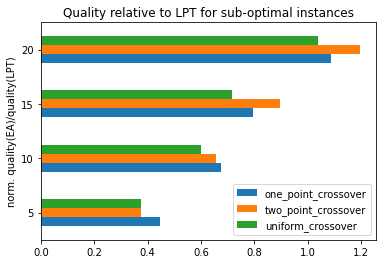

In [7]:
df = ea_df.sub(lpt_df.opt_bound, axis=0).div(lpt_df.lpt - lpt_df.opt_bound, axis=0)
df.plot.barh(xlabel='norm. quality(EA)/quality(LPT)', ylabel='#resources (R)', title='Quality relative to LPT for sub-optimal instances')